<a href="https://colab.research.google.com/github/pareshrchaudhary/kalmanfiltertutorial/blob/main/KalmanFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D Kalman Filter Walk Through

`Created by Paresh R. Chaudhary - University of Washington, Seattle`

##System

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Set a constant random seed
random.seed(42)

In [ ]:
def altitude_simulation(initial_altitude, turbulence_stddev, time_steps):
  a = 0.95  # Decreased altitude decrease rate
  initial_state = initial_altitude
  altitude = [initial_state]
  altitude_no_turbulence = [initial_state]

  for _ in range(time_steps):
    turbulence_current_time = random.gauss(0, turbulence_stddev)
    current_state = a * altitude[-1] + turbulence_current_time
    altitude.append(current_state)

    # Simulate altitude without turbulence
    current_state_no_turbulence = a * altitude_no_turbulence[-1]
    altitude_no_turbulence.append(current_state_no_turbulence)

  return altitude, altitude_no_turbulence

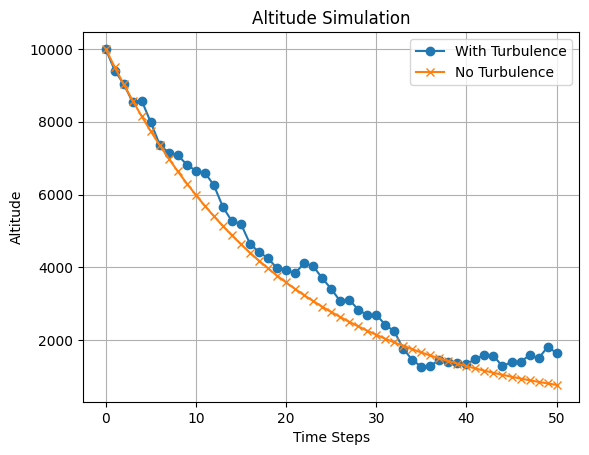

In [ ]:
initial_altitude = 10000  # Initial altitude in feet
turbulence_stddev = 200  # Standard deviation of turbulence noise
time_steps = 50  # Number of time steps to simulate

altitude_data, no_turbulence_data = altitude_simulation(initial_altitude, turbulence_stddev, time_steps)
time_steps = list(range(len(altitude_data)))

# Plot the altitude data
plt.plot(time_steps, altitude_data, label='With Turbulence', marker='o', linestyle='-')
plt.plot(time_steps, no_turbulence_data, label='No Turbulence', marker='x', linestyle='-')
plt.xlabel('Time Steps')
plt.ylabel('Altitude')
plt.title('Altitude Simulation')
plt.grid(True)
plt.legend()
plt.show()

## State Estimate

In [ ]:
def state_estimation(x_previous, z_current, gain):
  # Estimate the current state using the given gain
  x_estimate = x_previous + gain * (z_current - x_previous)

  return x_estimate

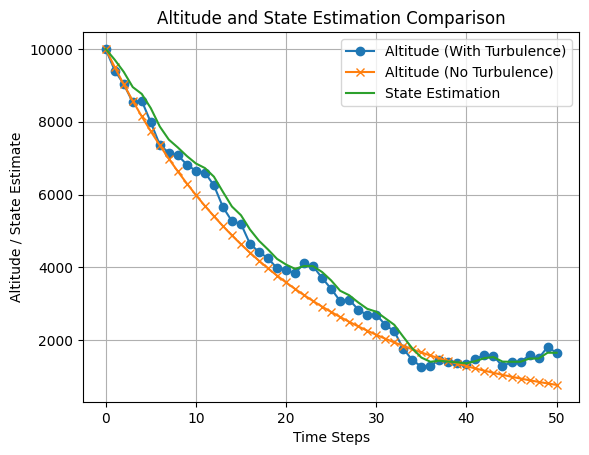

In [ ]:
initial_state_estimate = initial_altitude
gain = 0.5  # Adjust the gain for the state estimation

state_estimates = [initial_state_estimate]

# Perform state estimation
for i in range(1, len(altitude_data)):
    state_estimate = state_estimation(state_estimates[i - 1], altitude_data[i], gain)
    state_estimates.append(state_estimate)

# Plot the altitude data and state estimates
plt.plot(time_steps, altitude_data, label='Altitude (With Turbulence)', marker='o', linestyle='-')
plt.plot(time_steps, no_turbulence_data, label='Altitude (No Turbulence)', marker='x', linestyle='-')
plt.plot(time_steps, state_estimates, label='State Estimation', linestyle='-')
plt.xlabel('Time Steps')
plt.ylabel('Altitude / State Estimate')
plt.title('Altitude and State Estimation Comparison')
plt.grid(True)
plt.legend()
plt.show()

## Compute Gain

In [ ]:
def compute_gain(p_previous, r):
    g_k = p_previous / (p_previous + r)
    return g_k

def compute_prediction_error(p_previous, g_k):
    p_k = (1 - g_k) * p_previous
    return p_k

In [ ]:
# Initial values
r = 10.0  # Sensor's average noise
p_initial = 100.0  # Initial prediction error

# Compute the gain and the prediction error
g_k = compute_gain(p_initial, r)
p_k = compute_prediction_error(p_initial, g_k)

print(f"Gain (g_k): {g_k}")
print(f"Prediction Error (p_k): {p_k}")

Gain (g_k): 0.9090909090909091
Prediction Error (p_k): 9.090909090909093


## Kalman Filter

In [ ]:
def kalman_filter(initial_state_estimate, initial_prediction_error, r, altitude_data):
  # Lists to store the estimated states, prediction errors, and gains
  state_estimates = [initial_state_estimate]
  prediction_errors = [initial_prediction_error]
  gains = []

  for i in range(1, len(altitude_data)):
    # Prediction phase
    a = 0.95  # The constant a from the original state equation
    x_previous = state_estimates[i - 1]
    p_previous = prediction_errors[i - 1]

    x_predict = a * x_previous
    p_predict = a * p_previous * a

    # Update phase
    z_current = altitude_data[i]
    g_k = compute_gain(p_predict, r)
    x_estimate = x_predict + g_k * (z_current - x_predict)
    p_estimate = (1 - g_k) * p_predict

    # Store values for visualization
    gains.append(g_k)
    state_estimates.append(x_estimate)
    prediction_errors.append(p_estimate)

  return state_estimates, gains

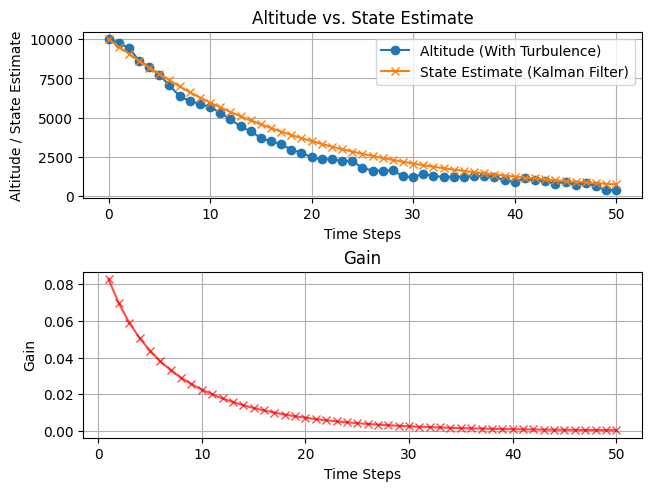

In [ ]:
# Parameters
initial_altitude = 10000  # Initial altitude in feet
turbulence_stddev = 200  # Standard deviation of turbulence noise
time_steps = 50  # Number of time steps to simulate
sensor_noise = 10.0  # Sensor's average noise

# Simulate altitude data with turbulence
altitude_data, _ = altitude_simulation(initial_altitude, turbulence_stddev, time_steps)

# Initial values for the Kalman filter
initial_state_estimate = altitude_data[0]
initial_prediction_error = 1.0

# Run the Kalman filter
state_estimates, gains = kalman_filter(initial_state_estimate, initial_prediction_error, sensor_noise, altitude_data)

# Create time steps
time_steps = list(range(len(altitude_data)))

# Plot the altitude data, state estimates, and gains
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])

# Plot the altitude data
ax1.plot(time_steps, altitude_data, label='Altitude (With Turbulence)', marker='o', linestyle='-')
ax1.plot(time_steps, state_estimates, label='State Estimate (Kalman Filter)', marker='x', linestyle='-')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Altitude / State Estimate')
ax1.set_title('Altitude vs. State Estimate')
ax1.grid(True)
ax1.legend()

# Plot the gain
ax2.plot(time_steps[1:], gains, label='Gain', marker='x', linestyle='-', alpha=0.7, color='red')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Gain')
ax2.set_title('Gain')
ax2.grid(True)
plt.show()

References:

1.   https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
2.   http://bilgin.esme.org/BitsAndBytes/KalmanFilterforDummies

